# Social Media and Human-Computer Interaction - Part 2


###  *Goal*: Use social media posts to explore the appplication of text and natural language processing to see what might be learned from online interactions.

Specifically, we will retrieve, annotate, process, and interpret Twitter data on health-related issues such as depression.

--- 
References:
* [Mining Twitter Data with Python (Part 1: Collecting data)](https://marcobonzanini.com/2015/03/02/mining-twitter-data-with-python-part-1/)
* The [Tweepy Python API for Twitter](http://www.tweepy.org/)

Required Software
* [Python 3](https://www.python.org)
* [NumPy](http://www.numpy.org) - for preparing data for plotting
* [Matplotlib](https://matplotlib.org) - plots and garphs
* [jsonpickle](https://jsonpickle.github.io) for storing tweets. 
---

In [22]:
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import jsonpickle
import json
import random

# Introduction

Analysis of social-media discussions has grown to be an important tool for biomedical informatics researchers, particularly for addressing questions relevant to public perceptions of health and related matters. Studies have examination of a range of topics at the intersection of health and social media, including studies of how [Facebook might be used to commuication health information](http://www.jmir.org/2016/8/e218/) how Tweets might be used to understand how smokers perceive [e-cigarettes, hookahs and other emerging smoking products](https://www.jmir.org/2013/8/e174/), and many others.

Although each investigation has unique aspects, studies of social media generally share several common tasks. Data acquisition is often the first challenge: although some data may be freely available, there are often [limits](https://dev.twitter.com/rest/public/rate-limits) as to how much data can be queried easily. Researchers might look out for [opportunities for accessing larger amounts of data](https://www.wired.com/2014/02/twitter-promises-share-secrets-academia/). Some studies contract with [commercial services providing fee-based access](https://gnip.com). 

Once a data set is hand, the next step is often to identify key terms and phrases relating to the research question. Messages might be annotated to indicate specific categorizations of interest - indicating, for example, if a message referred to a certain aspect of a disease or symptom. Similarly, key words and phrases regularly occurring in the content might also be identified. Natural language and text processing techniques might be used to extract key words, phrases, and relationships, and machine learning tools might be used to build classifiers capable of distinguishing between types of tweets of interest. 

This module presents a preliminary overview of these techniques, using Python 3 and several auxiliary libraries to explore the application of these techniques to Twitter data. 
  
  1. Configuration of tools to access Twitter data
  2. Twitter data retrieval
  3. Searching for tweets
  4. Annotation of tweets
  5. Natural Language Processing
  6. Examination of text patterns
  7. Construction of classifiers
  8. Exercises and next steps
  

Our case study will apply these topics to Twitter discussions of smoking and tobacco. Although details of the tools used to access data and the format and content of the data may differ for various services, the strategies and procedures used to analyze the data will generalize to other tools.

## 1. Configuration of tools to access Twitter data

[Twitter](www.twitter.com) provides limited capabilities for searching tweets through an Application Programming Interface (API) based on Representational State Transfer (REST).  [REST](https://doi.org/10.1145/337180.337228) is an approach to using web-based Hypertext-Transfer Protocol (HTTP) requests as APIs. 

Essentially, a REST API specifies conventions for HTTP requests that might be used to retrieve specific data items from a remote server. Unlike traditional HTTP requests, which return HTML markup to be rendered in web browsers, REST APIs return data formatted in XML or JSON, suitable for interpretation by computer programs. REST APIs from familiar websites underlie frequently-seen functionality such as embedded twitter widgets and "like/share" links, among others.

Commercial REST applications often use "API-Keys" - unique identifiers used to associate requests with registered accounts. Here, we will walk through the process of registering for Twitter API keys and using a Python library to manage the details of making a Twitter API request and receiving a response.

1.1 Registering for a Twitter API key

1.1.1 *Signup for Twitter* The first step in registering for a Twitter API key is to [signup](https://twitter.com/signup) for an account. If you dont' want to post anything or to use the account in any way that might be linked to your regular email adddress, you might want to create a special-purpose account using a service such as gmail, and use this new email address for the twitter account.

1.1.2. *Create a Twitter application*: Go to  [Twitter's developer site](https://dev.twitter.com) and click on "My Apps". Click on "Create New App" in the upper right and then fill out the form. The main thing that you need to focus on here is the application name, description, and website. The rest can be ignored.

Creating the application will lead to the display of some information with some URLs and a few tabs. Look under "Keys and Access Tokens" to see the Consumer API key and API Secret - these will come in handy later.

There will also be a button that says "Create my access token". Press this button and make a note of the Access Token and Access Token Secret values that are displayed. 

Although hese tokens are always available on the application page, for the purpose of this exercise, it's best to store them in Python variables directly in this Jupyter notebook. Execute the following insstructions, substituting the keys for your application for the phrases "YOUR-CONSUMER-KEY", etc. 

In [2]:
consumer_key = 'YOUR-CONSUMER-KEY'
consumer_secret = 'YOUR-CONSUMER-SECRET'
access_token = 'YOUR-ACCESS-TOKEN'
access_secret = 'YOUR-ACCESS-SECRET'

### *Note that the following should be redacted*

In [1]:
consumer_key='D2L4YZ2YrO1PMix7uKUK63b8H'
consumer_secret='losRw9T8zb6VT3TEJ9JHmmhAmn1GXKVj30dkiMv9vjhXuiWek9'
access_token='15283934-iggs1hiZAPI2o5sfHWMfjumTF7SvytHPjpPRGf3I6'
access_secret='bOvqssxS97PGPwXHQZxk83KtAcDyLhRLgdQaokCdVvwFi'

In theory, you know have all that you need to start accessing Twitter. Using these keys and the information in the [Twitter Developer Documentation](https://dev.twitter.com/docs), you might conceivably create web requests to search for tweets, post, and read your timeline. In practice, it's a bit more complicated, so most folks use third-party tools that take care of the hard work. 

1.1.3 *Try the Tweepy library*: [Tweepy](http://www.tweepy.org) is a Python 3 library for using the Twitter API. Like other similar libraries - there are many for Python and other languages - Tweepy takes care of the details of authorization and provides a few simple function calls for accessing the API.  

The first step in using Tweepy is *authorization* - establishing your credentials for using the Twitter API. Tweepy uses the [OAuth](http://www.oauth.net) authorization framework, which is widely used for both API and user access to services provided over HTTP. Fortunately Tweepy hides the oauth details. All you need to do is to make a few calls to the Tweepy library and you're all set to go. Run the following code, making sure that the four variables are set to the values you were given when you registered your Twitter application:

In [2]:
import tweepy
from tweepy import OAuthHandler

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth)

If this worked correctly, you should see something like this 
```
<tweepy.api.API at 0x109da36d8>
``` 

If you get an error message, please check your keys and tokens to ensure that they are correct.

## 2. Twitter data retrieval

Now that you have successfully accessed the Twitter API, it's time to access the data. The simplest thing to do is to grab some Tweets off of your timeline. Try the following code:

In [3]:
top_ten = []
i =0
for tweet in tweepy.Cursor(api.home_timeline).items(10):
    top_ten.append(tweet._json)
    

There are several key componnents to this block of code:
* ```api.home_timeline``` is a component of the API object, referring to the user timeline - the tweets shown on your home page.
* ```tweepy.Cursor``` is a construct in the Tweepy API that supports navigation through a large set of results.
* ```tweepy.Cursor(api.home_timeline).items(10)``` essentially asks Tweepy to set up a cursor for the home timeline and then to get the first 10 items in that set. The result is a Python Iterator, which can be used to examine the items in the set in turn.
* We will grab the JSON representation of each tweet (stored as "tweet.\_json") for maximum flexibility.
* The loop takes each of those objects an adds them into a Python array.

Now, each of the items in ```top_ten``` is a Tweet object. Let's take a look inside. We'll start by grabbing the first text:

In [4]:
tweet1=top_ten[0]

and looking at its text:

In [5]:
tweet1['text']

'45/ Prince now "can\'t remember" if Bannon told him the UAE met with Flynn *prior* to him (Prince) going to the Seyc… https://t.co/QC5KJsyaLb'

.. noting that the text is roughly 140 characters long...

In [6]:
len(tweet1['text'])

140

We can also examine when the tweet was created...

In [7]:
tweet1['created_at']

'Thu Dec 07 19:15:51 +0000 2017'

.. whether it has been favorited...

In [8]:
tweet1['favorited']

False

.. The unique ID String of the Tweet...

In [9]:
tweet1['id_str']

'938849556204224514'

.. and the name of the Twitter user responsible for the post. 

In [10]:
tweet1['user']['name']

'Seth Abramson'

In [11]:
tweet1=top_ten[1]

In [12]:
tweet1['id_str']

'938849424004050944'

We can check to see if a tweet is a retweet by seeing if it has the 'retweeted_status' attribute.

In [13]:
'retweeted_status' in tweet1

False

You can also see if your tweet was a retweet. If it was, the <em>retweeted_status</em> field will hold information about the original tweet

In [14]:

if 'retweeted_status' in tweet1:
    original = tweet1['retweeted_status']
    print(original['user']['name'])
else:
    print("not a rewteet")

not a rewteet


The twitter API supports many other details for users, tweets, and other entities. See [The Twitter API Overview](https://dev.twitter.com/overview/api) for general details and subpages about [Tweets](https://dev.twitter.com/overview/api/tweets), [Users](https://dev.twitter.com/overview/api/users) and related pages for specific details of other data types.

## 3. Searching for tweets

Our next major goal will be to search for Tweets. Effective searching requires both construction of useful queries (the hard part) and use of the Tweepy search API (the easy part).

### 3.1 Formulating a query

Formulating an effective search query is often a challenging, iterative process. Trying some searches in the Twitter web page is a good way to see both how a query might be formulated and which queries might be most useful.

If you look carefully at the URL bar in your browser after running a search, you might notice that the search term is embedded in the URL. Thus, if you search for "depression", you might see a URL that looks like https://twitter.com/search?q=depression. You might also see "&src=typed" at the end of the URL, indicating that the search was typed by hand.

You can also use Tweepy to conduct a search, as follows:

In [15]:
tlist = api.search("smoking",lang="en",count=10)
tweets = [t._json for t in tlist]

This search will find the first 10 English tweets matching the term "depression".

In [16]:
tweets[0]['text']

'women in leotards having sex pic playboy nudes smoking cigarettes https://t.co/Wsv2tVNvqZ'

We can then look at the text for these tweets. This is a good way to check to ensure that we're getting what we think we should be getting.

In [17]:
texts = [c['text'] for c in tweets]

In [18]:
texts

['women in leotards having sex pic playboy nudes smoking cigarettes https://t.co/Wsv2tVNvqZ',
 'RT @smlungpathguy: @gibbspath Good question! No data to back this up but never smokers are more likely to have grossly pristine lungs. My h…',
 'RT @mickeastcoast88: wanna ride around smoking blunts and look at christmas lights!!!!!!',
 'RT @UraSwallow: Eating his cumshot, the smoking hot Juelz Ventura! #Blowjob #Cocksucking #SwallowsSemen #CumEaters #BJ #Cocksuckers https:/…',
 'RT @SusanNow3: Time to call for Roy Moore to step down! #NoMoore\nBreaking: Smoking Gun Evidence Surfaced Proving Roy Moore Is Guilty (Video…',
 'RT @homerotaffinder: Been smoking my feelings lately',
 'My mom found my vape and she’s trippen asking me what I’m smoking 😂😂😂 #HispanicParents',
 '@s2ck2n Stayed away from Waffle Houses when smoking was permitted.',
 'Chilling in the Bando Smoking on the Indo 💨!!',
 '@Smexc_ Lmfao just don’t say we smoking dicks and we good']

You may see some tweets that don't match exactly - perhaps using 'depressed' instead of 'depression'. This suggests that Twitter uses <em>stemming</em> - removing suffixes and variations to get to the core of the word - to increase search accuracy.

At this point, we should be able to evaluate the results to see if we are on the right track. If we aren't, we'd want to try some different queries. For now, it looks good, so let's move on.

### 3.2 Collecting and characterizing a larger corpus

Our original query only retrieved 10 tweets. This is a good start, but probably not enough for anything serious. We can loop through several times to create a longer list, with a delay between searches to avoid overstaying our welcome with Twitter:

In [21]:
import time
for i in range(10):
    new_tweets = api.search("smoking",lang="en",count=100)
    nt = [t._json for t in new_tweets]
    tweets= tweets+nt
    time.sleep(5)
    

In [22]:
len(tweets)

1010

At this point, we might want to know something about the tweets that we have retrieved. As our goal is to shoot for linguistic diversity, we want to make sure that we don't have too many retweets, and that we have a wide range of authors. Let's run through the tweets and count the number of authors and retweets. We can count authors in a dictionary and retweets in a simple variable.

In [23]:
authors={}
retweets=0
for t in tweets:
    # is it a retweet? If so, increment
    if 'retweeted_status' in t:
        retweets = retweets+1
    # get tweet author name
    uname = t['user']['name']
    # if not in authors, put it in with zero articles
    if uname not in authors:
        authors[uname]=0
    authors[uname]=authors[uname]+1

In [24]:
retweets

609

In [25]:
len(tweets)

1010

In [26]:
len(authors.keys())

122

We might see a lot of retweets here - I saw at least 80% in one instance, with about 193 authors. This suggests that this corpus has a good many authors with multiple tweets. 

To explore this, let's look at the histogram of the number of tweets/author.

To examine the distribution of authors, we can use the [NumPy](http://www.numpy.org) and [Matplotlib](http://matplotlib.org) libraries to extract the number of tweets from each user (given by authors.values()) and to plot a histogram...

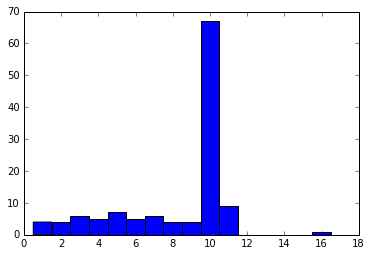

In [27]:
vals = np.array(list(authors.values()))
#plt.xticks(range(min(vals),max(vals)+1))
plt.hist(vals,np.arange(min(vals)-0.5,max(vals)+1.5));

It looks like a broad range of the number of tweets/user, up until roughly tweets, with many users having 10 tweets. This is an intersting pattern, with no immediately obvious interpretation. Understanding the usage patterns might be an intersting area for further work, although larger data sets might be necessary to see meaningful patterns.

Given the number of retweets and the frequency of posting by some authors, we might be concnered that we are seeing repeated tweets.  To check this, we will review the  tweet IDs in a manner similar to that  which we used for the authors, to see how many of the tweets are unique. 

As we do this, we'll create a dictionary that will allow us to retrieve tweets by IDs. Specifically, we will create a new diectionary entitled Each `utweets`. This dictionary will be indexed by the ID string of the tweet. Each element of the dictionary will itself be a dictionary, withe the following contents:

* 'tweet' will refer to the full tweet
* 'count' contains the number of times it occurs in the dataset. 

Later, we'll add to this structure. 

In a more complete program, we might use Object-Oriented programming to wrap the data in a [Python Class](https://docs.python.org/3/tutorial/classes.html), but that would add more complexity that we don't want to get into here. 

For now, we'll proceed by building up the dictionary of tweets.

In [28]:
utweets={}
for t in tweets:
    id = t['id_str']
    if id not in utweets:
        new_entry={}
        new_entry['count']=0
        new_entry['tweet']=t
        utweets[id]=new_entry
        
    utweets[id]['count']=utweets[id]['count']+1
len(utweets)

123

Now, we can turn this dictionary into a list of id, count pairs, sort by count, and see which ones were repeated most often.

In [29]:
ps = []
for t,entry in utweets.items():
    count = entry['count']
    ps.append((t,count))  
ps.sort(key=lambda x: x[1],reverse=True)

Hmm.. only a small portion of our tweets are unique

In [30]:
float(len(utweets))/float(len(tweets))

0.12178217821782178

let's take a look at the most common

In [31]:
ps[1:10]

[('932445243932323840', 11),
 ('932445330704031745', 11),
 ('932445294960300033', 11),
 ('932445223212535810', 11),
 ('932445301306200064', 11),
 ('932445284315090950', 11),
 ('932445302065385472', 11),
 ('932445329429090304', 11),
 ('932445300102389760', 11)]

So, many tweets were seen 10 or more times. Let's take a look at them

In [32]:
for i in range(10):
    idstr = ps[i][0]
    count = ps[i][1]
    tweet = utweets[idstr]['tweet']
    text= tweet['text']
    print(idstr+" "+text+" "+str(count))

932445310768549889 To die from smoking weed you would have to smoke 15,000 pounds in 15 minutes 11
932445243932323840 RT @nutrition_facts: When smoking can use up the antioxidants contained in the equivalent of 200 cups of kale, you know it’s time to quit h… 11
932445330704031745 RT @GetOnSwag: JIN #BTS 171119 #AMAs2017 #amas' #JIN #방탄소년단 #진  #석진
SAINT LAURENT - ICONIC LE SMOKING CROPPED JACKET IN BLACK GRAIN DE POUD… 11
932445294960300033 RT @lulmaddie_: do NOT try and kiss me after you get done smoking a cigarette that shit is gross 🤮 11
932445223212535810 RT @sacredsmokes: @defelcj @CigarChairman @joe_boca @oppyBOTL @Mack280 @BoneMaCracken @FTBMelanie @WesSmith62 @CigarJedi @CigarsNearMe @Pis… 11
932445301306200064 RT @AsaAkira2016: Via: https://t.co/U785euxkh4
Smoking hot asian babe in stockings Asa Akira slipping off her lingerie https://t.co/biMGaEY… 11
932445284315090950 @hapa_girl33 @chrischocolate7 @TuleTwilight @BillOReilly @seanhannity Nah, he's showing you a two in one. Han

This leads to a question - how can we generate a large set of unique tweets, so as to ensure diversity of results? Our techniques for checking uniquness provide an answer. We can retrieve tweets, checking as we go to see if we've seen them before, and discaring tweets that are repeats. This will continue until we have a large enough set.

To do this, we'll have a structure similar to what we used before: 
* tweets will be a dictionary, keyed by the id string of the tweet
* each entry will include a count of the number of times that tweeet was seen, and the tweet itself

This may seem a bit cumbersome, but there's an advantage - if we use a structure like this, it becomes very easy to store it to disk, providing a dataset that can easily be shared and reused.

Finally, we can store this in a function, allowing us to re-run the search for a different set of terms.

In [33]:
def searchTwitter(term,corpus_size):
    tweets={}
    while (len(tweets) < corpus_size):
        new_tweets = api.search(term,lang="en",count=10)
        for nt_json in new_tweets:
            nt = nt_json._json
            if nt['id_str'] not in tweets:
                new_entry={}
                new_entry['count']=0
                new_entry['tweet']=nt
                tweets[nt['id_str']]=new_entry
            tweets[nt['id_str']]['count'] = tweets[nt['id_str']]['count']+1
        # wait to give our twitter account a break..
        time.sleep(10)
    return tweets

In [34]:
tweets = searchTwitter("smoking",100)

### 3.3 Saving tweets, Loading tweets, and Verifying results

Now, we've got a good solid set of tweets to work with. Let's save these tweets to a file, using the [jsonpickle](https://jsonpickle.github.io/) library to convert the strucure into a json file, which we will then write to disk. We'll define a function to do this, as we might want to repeat this later.

In [35]:
def saveTweets(tweets,filename):
    json_data =jsonpickle.encode(tweets)
    with open(filename,'w') as f:
        json.dump(json_data,f)

In [36]:
saveTweets(tweets,'tweet.json')

Now that that's done, we can read it in again. Once again, we'll write a function.

In [20]:
def readTweets(filename):
    with open(filename,'r') as f:
        json_data = json.load(f)
    tweets = jsonpickle.decode(json_data)
    return tweets

Let's  do some quick checks to confirm that we've got the right data out. Note that in future runs, you can just start here to read in your tweets.

In [38]:
tweets2 = readTweets('tweet.json')

In [39]:
len(tweets2)

109

In [40]:
tweets == tweets2

True

[According to Python documentation](https://docs.python.org/2/reference/expressions.html#id24) dictionaries are equal if the keys and values are equal, so this looks good. To check in more detail, we can look at the keys, using subtraction to indicate set difference:

In [41]:
tweets.keys()-tweets2.keys()

set()

To confirm, we might look specifically at some tweets.. we'll  find an ID and grab the structures out of each list, reviewing for comparable values.

In [42]:
tweet_id=random.choice(list(tweets.keys()))

In [43]:
t1 = tweets[tweet_id]
t2= tweets2[tweet_id]

In [44]:
t1['tweet']['text']

"RT @AaronTheHooper: Yall be smoking with y'all momma's and cussing with y'all momma's.. I can't relate"

In [45]:
t2['tweet']['text']

"RT @AaronTheHooper: Yall be smoking with y'all momma's and cussing with y'all momma's.. I can't relate"

In [46]:
t1==t2

True

Spot checks like this give some confidence that the loaded tweets are identical to the saved tweets. We might also run a slightly more rigorous check by iterating through the list to look for similarities. Since we know that the two dictionaries have identical sets of keys, we can iterate through the keys of one to get entries and compare equalities.

In [47]:
errs =[]
for id in tweets.keys():
    t1 =tweets[id]
    t2 = tweets2[id]
    if t1 != t2:
        errs.append(id)

In [48]:
errs

[]

Great. No errors...

## 3.4 Some final notes
Note that we might find that we will want to add additional fields to this file. We can always rewreite the file as needed. Saving the file as is gives us a good record that we can work from, without having to recreate the dataset. For subsequent exercises, you can start from this line, without running any of the prior code..

## 4. Annotating Tweets

### 4.1 Open Coding

Now that we have a corpus of tweets, what do we want to do with them? Turning a relatively vague notion into a well-defined research question is often a significant challenge, as examination of the data often reveals both shortcomings and unforeseen opportunities.

In our case, we are interested in looking at tweets about depression, but we're not quite sure exactly *what* we are looking for. We have a vague notion that we might learn something interesting, but understanding exactly what that is, and what sort of analyses we might need, will require a bit more work.

In situations such as this, we might look at some of the data to form some preliminary impressions of the content. Specifically, we can look at indidividual tweets, assigning them to one or more categories - known as *codes* - based on their content.  We can add categories as needed to capture important ideas that we might want to refer back to. This practice - known as *open coding* allows us to begin to make sense of unfamiliar data sets. 

This sounds much more complicated than it is. For now, let's read some tweets in from a file (using the procedure defined above), and then we can get to work.

In [23]:
tweets =readTweets("tweet-corpus.json")

We will begin by taking a look at a subset of 100 tweets.  Keep in mind that *tweets* is a dictionary mapping id strings to information about tweets. Each entry in *tweets* is itself a dictionary, with 'count' corresponding to the number of times the tweet was sound, and 'tweet' corresponding to the tweet itself.  We're going to add some categories to that dictionary, but we need to start by getting a smaller set of tweets.

To get this list, we'll sort the ids of the tweets and take the first 10 in the list. 

In [24]:
ids=list(tweets.keys())
ids.sort()
working=[]
for i in range(100):
    id = ids[i]
    entry = tweets[id]
    working.append(entry)

*working* now has 100 tweets. Let's start with the first.

In [25]:
td = working[0]

In [26]:
td['tweet']['text']

'FlTNESS: RT DrugedPosts: "Wyd after smoking this?" https://t.co/OnLywTyJ0X'

This tweet has several interesting charcteristics.
1. it is a retweet
2. It contains a link. 

We can model all of these points through relevant annotation. Specifically, we will add two new arrays to each tweet object. 'code' will contain a list of categorical annotations associated with the tweet.

In [53]:
td['code']=[]
td['code'].append('LINK')
td['code'].append("RETWEET")

We can confirm that this is a rewtweet by checking for the `retweeted_status` attribute

In [54]:
'retweeted_status' in td['tweet']

False

Hmm. the attribute is not present. Perhaps the user copied the text and added 'RT' without actually retweeting? Something to keep our eyes on for other tweets.

let's look at the next tweet. 

In [55]:
td = working[1]
td['tweet']['text']

'RT DrugedPosts: "Wyd after smoking this?" https://t.co/PZ3YyYh8WB'

Notice this is similar, but not identical, to the previous tweet. 

In [56]:
td['code']=[]
td['code'].append('LINK')
td['code'].append('RETWEET')

In [57]:
'retweeted_status' in td['tweet']

False

ok.. moving on to the third tweet..

In [58]:
td = working[2]
td['tweet']['text']

'RT @Anzers: #TheBetrayalPapers Video: Part II – In Plain Sight – A National Security Smoking Gun\nhttps://t.co/rpObdW9GcG'

This retweet includes a link, a hashtag reference, and a reference to a `Smoking gun`, suggesting that this is not really a tweet about tobacco, marijuana, or other smoking products. We'll label it `irrelevant`

In [59]:
td['code']=[]
td['code'].append('RETWEET')
td['code'].append('LINK')
td['code'].append('USERMENTION')
td['code'].append('HASHTAG')
td['code'].append('IRRELEVANT')

In [60]:
'retweeted_status' in td['tweet']

True

next...

In [61]:
td = working[3]
td['tweet']['text']

'RT @FootyMemes: This new anti-smoking ad is really powerful... https://t.co/pWHZDLIb7O'

Here, we have have a retweet, a link, and something about anti-smoking

In [62]:
td['code']=[]
td['code'].append('RETWEET')
td['code'].append('LINK')
td['code'].append('ANTI-SMOKING')

In [63]:
'retweeted_status' in td['tweet']

True

In [64]:
td = working[4]
td['tweet']['text']

'@ericschmidt @jwnichls Stop. You need to stop torturing me. No buddy nobody cares about "smoking." Stop.'

This retweet includes user mentions. It might or might not be relevant. 

In [65]:
td['code']=[]
td['code'].append("USERMENTION")
td['code'].append("FRUSTRATION")
td['code'].append("POSSIBLYRELEVANT")

In [66]:
td = working[5]
td['tweet']['text']

'RT @FurnyFootball: Stop smoking 😂 https://t.co/bY1ZvJy63Z'

A retweet with a user mention, and anti-smoking message, and a link

In [67]:
td['code']=[]
td['code'].append("RETWEET")
td['code'].append("USERMENTION")
td['code'].append("ANTI-SMOKING")
td['code'].append("LINK")

In [68]:
td = working[6]
td['tweet']['text']

'You ever wake up and wish you was still sleep? ... that’s me rn.'

This tweet doesn't seem to be about smoking.

In [69]:
td['code']=[]
td['code'].append("IRRELEVANT")

In [70]:
td = working[7]
td['tweet']['text']

'"Resorted to...". Hahahaha..!  Way to be strong and brave unaided...!  Hahahaha...!  https://t.co/Lnd9N3zBCY via @YahooNews'

This tweet includes a user mention, and a link, but doesn't seem to be relevant to smoking

In [71]:
td['code']=[]
td['code'].append("USERMENTION")
td['code'].append("LINK")
td['code'].append("IRRELEVANT")


In [72]:
td = working[8]
td['tweet']['text']

'RT @chocoo_loco: I just want my friends to stop smoking weed😂 https://t.co/LWI2HVofAf'

This is a retweet with a link, a user mention, and an expression of a desire that the user's friends top smoking marijuana.

In [73]:
td['code']=[]
td['code'].append("RETWEET")
td['code'].append("USERMENTION")
td['code'].append("LINK")
td['code'].append("ANTI-SMOKING")
td['code'].append("MARIJUANA")
td['code'].append("FRIENDS")
td['code'].append("SENTIMENT")

and so it goes. You might have to code 100 or more tweets to get a good distribution. You'll work on this in a minute, but first, a suggestion. As you code, it might be hard to track which of the codes you've used. Let's write a routine to collect those codes. Printing this list on occassion will help you remeber what you've used and ensure that you don't miss opportunities to reuse code.

In [74]:
def getCodes(tweets):
    codes =[] 
    for id,entry in tweets.items():
        # for every tweet, look to see if we have any codes
        if 'code' in entry:
            # for each code
            for code in entry['code']:
            # look for it in the codeDictionary, creating a new list of codes if needed
                if code not in codes:
                    codes.append(code)
    return codes

In [75]:
getCodes(tweets)

['IRRELEVANT',
 'LINK',
 'RETWEET',
 'USERMENTION',
 'FRUSTRATION',
 'POSSIBLYRELEVANT',
 'ANTI-SMOKING',
 'HASHTAG',
 'MARIJUANA',
 'FRIENDS',
 'SENTIMENT']



## EXERCISE 1: Code the Next 50 tweets in the set. 
Start with the tags used above, adding your own as needed.  

--- 
### answer - cut below this line
Following lines to be deleted when provided for student use

In [76]:
td = working[9]
td['tweet']['text']

'No kidding... https://t.co/3Kg2HkfRsc'

In [77]:
td['code']=[]
td['code'].append("LINK")
td['code'].append("IRRELEVANT")

In [78]:
td = working[10]
td['tweet']['text']

'RT @xancaps: smoking by myself now\n\ni don’t need nobody else around'

In [79]:
td['code']=[]
td['code'].append("RETWEET")
td['code'].append("USERMENTION")
td['code'].append("HABITS")

In [80]:
td = working[11]
td['tweet']['text']

'RT @GiveMeInternet: Anti smoking ads should show the benefits of quitting instead of the harms of smoking.'

In [81]:
td['code']=[]
td['code'].append("RETWEET")
td['code'].append("USERMENTION")
td['code'].append("ANTI-SMOKING")
td['code'].append("QUITTING")

In [82]:
td = working[12]
td['tweet']['text']

'@Austin_Sosbee See I have recently started to dream again, Why again? Cause smoking alot of weed stops dreaming, I miss not dreaming lol'

In [83]:
td['code']=[]
td['code'].append("RETWEET")
td['code'].append("USERMENTION")
td['code'].append("MARIJUANA")
td['code'].append("BENEFITS")

In [84]:
td = working[13]
td['tweet']['text']

'RT @FootyMemes: This new anti-smoking ad is really powerful... https://t.co/pWHZDLIb7O'

In [85]:
td['code']=[]
td['code'].append("RETWEET")
td['code'].append("USERMENTION")
td['code'].append("LINK")
td['code'].append("ANTI-SMOKING")

In [86]:
td = working[14]
td['tweet']['text']

'RT @GiveMeInternet: Anti smoking ads should show the benefits of quitting instead of the harms of smoking.'

In [87]:
td['code']=[]
td['code'].append("RETWEET")
td['code'].append("USERMENTION")
td['code'].append("ANTI-SMOKING")
td['code'].append("QUITTING")

In [88]:
td = working[15]
td['tweet']['text']

"Mngxitama and his nyaope smoking buddies were a no show today because the Guptas aren't targeted hahahaha"

In [89]:
td['code']=[]
td['code'].append("FRIENDS")

In [90]:
td = working[16]
td['tweet']['text']

'RT @_youngkingdave: Smoking #doinks with @WakaFlocka\n#doinksquad https://t.co/zex6zRw4Xx'

In [91]:
td['code']=[]
td['code'].append("RETWEET")
td['code'].append("USERMENTION")
td['code'].append("LINK")
td['code'].append("MARIJUANA")

In [92]:
td = working[17]
td['tweet']['text']

'RT @OnlyWayIsShawtz: My boy stopped smoking weed the day he spent 30 minutes looking for his phone under the bed.. While using his phone fl…'

In [93]:
td['code']=[]
td['code'].append("RETWEET")
td['code'].append("USERMENTION")
td['code'].append("MARIJUANA")
td['code'].append("IMPACT")

In [94]:
td = working[18]
td['tweet']['text']

'RT @GiveMeInternet: Anti smoking ads should show the benefits of quitting instead of the harms of smoking.'

In [95]:
td['code']=[]
td['code'].append("RETWEET")
td['code'].append("USERMENTION")
td['code'].append("ANTI-SMOKING")
td['code'].append("QUITTING")

In [96]:
td = working[19]
td['tweet']['text']

"i @KattyKayBBC 'Cannabis is a gateway 2 taking Heroin' were did u hear that pish? Joint smoking 1 day next injecting in2 souls of feet no-no"

In [97]:
td['code']=[]
td['code'].append("USERMENTION")
td['code'].append("MARIJUANA")
td['code'].append("OPIATES")

In [98]:
td = working[20]
td['tweet']['text']

"https://t.co/qchtcveqkA is the world's 1st Smoking Model directory. Search for your favorite… https://t.co/21OlmjWv7Z"

In [99]:
td['code']=[]
td['code'].append("LINK")
td['code'].append("IRRELEVANT")

In [100]:
td = working[21]
td['tweet']['text']

'RT @_youngkingdave: Smoking #doinks with @WakaFlocka\n#doinksquad https://t.co/zex6zRw4Xx'

In [101]:
td['code']=[]
td['code'].append("RETWEET")
td['code'].append("USERMENTION")
td['code'].append("LINK")
td['code'].append("MARIJUANA")

In [102]:
working[21]['tweet']['id_str']==working[16]['tweet']['id_str']

False

good. no repeat

In [103]:
td = working[22]
td['tweet']['text']

'@LaurenSocha Make sure people wash who come in to close contact with her, no smoking near her or change smokey clot… https://t.co/iveJEh9sfT'

In [104]:
td['code']=[]
td['code'].append("USERMENTION")
td['code'].append("LINK")
td['code'].append("ADVICE")

In [105]:
td = working[23]
td['tweet']['text']

'RT @wifisfuneral: I love you always brother &amp; I’m proud how far you’ve gone I remember riding in your whips smoking ports plotting on this…'

In [106]:
td['code']=[]
td['code'].append('RETWEET')
td['code'].append("USERMENTION")
td['code'].append("POSITIVEAFFECT")

In [107]:
td = working[24]
td['tweet']['text']

"RT @The_AOP: Well done to everyone who's got this far! Find out how smoking can impact your eye health in our blog: https://t.co/wCxqBvJxdX…"

In [108]:
td['code']=[]
td['code'].append('RETWEET')
td['code'].append("USERMENTION")
td['code'].append("LINK")
td['code'].append("INFORMATION")
td['code'].append("ANTI-SMOKING")

In [109]:
td = working[25]
td['tweet']['text']

'RT @DrugedPosts: "Wyd after smoking this?" https://t.co/n3eGNF4ywY'

In [110]:
td['code']=[]
td['code'].append('LINK')
td['code'].append("RETWEET")

In [111]:
td = working[26]
td['tweet']['text']

'RT @_youngkingdave: Smoking #doinks with @WakaFlocka\n#doinksquad https://t.co/zex6zRw4Xx'

In [112]:
td['code']=[]
td['code'].append("RETWEET")
td['code'].append("USERMENTION")
td['code'].append("LINK")
td['code'].append("MARIJUANA")

In [113]:
td = working[27]
td['tweet']['text']

'@FoodTrapper stop smoking cigarettes.'

In [114]:
td['code']=[]
td['code'].append("USERMENTION")
td['code'].append("ANTI-SMOKING")

In [115]:
td = working[28]
td['tweet']['text']

'Smoker? Learn how quitting cuts your #risk of #heartdisease in half: https://t.co/vRLhuXIF1w https://t.co/CbifCvSthc #livewell #2health'

In [116]:
td['code']=[]
td['code'].append('ANTI-SMOKING')
td['code'].append('LINK')
td['code'].append('ADVICE')

In [117]:
td = working[29]
td['tweet']['text']

'RT @onmyworst: Not to sound like tana mongeau but I love smoking weed'

In [118]:
td['code']=[]
td['code'].append('RETWEET')
td['code'].append('USERMENTION')
td['code'].append('MARIJUANA')
td['code'].append("POSITIVEAFFECT")

In [119]:
td = working[30]
td['tweet']['text']

'Max has been growing some odd vegetables and smoking them recently. I must investigate further.'

In [120]:
td['code']=[]
td['code'].append('VEGETABLES')

In [121]:
td = working[31]
td['tweet']['text']

'@KBonimtetezi @WilliamsRuto We need to get urine sample coz what you are smoking??'

In [122]:
td['code']=[]
td['code'].append('USERMENTION')
td['code'].append("DRUGTESTING")

In [123]:
td = working[32]
td['tweet']['text']

'Drinking a Petite Sour Raspberry by @CrookedStave @ Meat Smoking House 2 — https://t.co/jp3qqNwAgc #photo'

In [124]:
td['code']=[]
td['code'].append("LINK")
td['code'].append("IRRELEVANT")

In [125]:
td = working[33]
td['tweet']['text']

"So high that I'm fading away ..."

In [126]:
td['code']=[]
td['code'].append("MARIJUANA")

In [127]:
td = working[34]
td['tweet']['text']

'RT @Bhuvan_Bam: @CarryMinati *Stresses out*\n*Starts smoking* 😭😭😂'

In [128]:
td['code']=[]
td['code'].append("USERMENTION")
td['code'].append("POSITIVEAFFECT")

In [129]:
td = working[35]
td['tweet']['text']

"RT @foxnewspolitics: 'Smoking gun'email shows Obama DOJ blocked conservative groups from settlement funds,GOP lawmaker says- @AlexPappas\nht…"

In [130]:
td['code']=[]
td['code'].append("RETWEET")
td['code'].append("USERMENTION")
td['code'].append("IRRELEVANT")

In [131]:
td = working[36]
td['tweet']['text']

'RT @DrugedPosts: "Wyd after smoking this?" https://t.co/n9g9TkPqDM'

In [132]:
td['code']=[]
td['code'].append("RETWEET")
td['code'].append("USERMENTION")
td['code'].append("LINK")

In [133]:
td = working[37]
td['tweet']['text']

'RT @skwawkbox: This is huge if people understand its significance...\nhttps://t.co/IcEi2Gh1fh'

In [134]:
td['code']=[]
td['code'].append("RETWEET")
td['code'].append("USERMENTION")
td['code'].append("LINK")
td['code'].append("IRRELEVANT")

In [135]:
td = working[38]
td['tweet']['text']

"RT @Sesamee_giraffe: Sana's introduction is a perfect example of smoking through your presentation 😂"

In [136]:
td['code']=[]
td['code'].append("RETWEET")
td['code'].append("USERMENTION")
td['code'].append("IRRELEVANT")

In [137]:
td = working[39]
td['tweet']['text']

'RT @Bhuvan_Bam: @CarryMinati *Stresses out*\n*Starts smoking* 😭😭😂'

In [138]:
td['code']=[]
td['code'].append("USERMENTION")
td['code'].append("POSITIVEAFFECT")

In [139]:
td = working[40]
td['tweet']['text']

'RT @phil30mccrackin: Smoking hot Funtime babes @ashlyandersonxx &amp; @missjojokiss https://t.co/CExJIai8ZW'

In [140]:
td['code']=[]
td['code'].append("RETWEET")
td['code'].append("USERMENTION")
td['code'].append("LINK")
td['code'].append("IRRELEVANT")

In [141]:
td = working[41]
td['tweet']['text']

'RT @WeedFeed: Differences Between Eating And Smoking Weed https://t.co/8FK10ZbWqx https://t.co/l6212vXpA7'

In [142]:
td['code']=[]
td['code'].append("RETWEET")
td['code'].append("USERMENTION")
td['code'].append("LINK")
td['code'].append('MARIJUANA')

In [143]:
td = working[42]
td['tweet']['text']

'@danielmarven He must stop smoking 😂😂😂 https://t.co/8tzUrn9Jem'

In [144]:
td['code']=[]
td['code'].append("RETWEET")
td['code'].append("LINK")
td['code'].append("ANTI-SMOKING")

In [145]:
td = working[43]
td['tweet']['text']

'RT @GiveMeInternet: Anti smoking ads should show the benefits of quitting instead of the harms of smoking.'

In [146]:
td['code']=[]
td['code'].append("RETWEET")
td['code'].append("USERMENTION")
td['code'].append("ANTI-SMOKING")
td['code'].append("QUITTING")

In [147]:
td = working[44]
td['tweet']['text']

'RT @DrugedPosts: "Wyd after smoking this?" https://t.co/n9g9TkPqDM'

In [148]:
td['code']=[]
td['code'].append('LINK')
td['code'].append("RETWEET")

In [149]:
td = working[45]
td['tweet']['text']

'“What Were They Smoking?”: On Liturgical Art from the 1970s https://t.co/dOgDAUDoVr https://t.co/CcQEkOrIW1'

In [150]:
td['code']=[]
td['code'].append('LINK')

In [151]:
td = working[46]
td['tweet']['text']

"RT @Prime_Politics: Fmr. House Speaker Boehner Describes How Obama Struggled With Smoking and Was 'Scared to Death' of Michelle\n\n#P2 https:…"

In [152]:
td['code']=[]
td['code'].append('RETWEET')
td['code'].append('USERMENTION')
td['code'].append('LINK')

In [153]:
td = working[47]
td['tweet']['text']

'RT @GiveMeInternet: Anti smoking ads should show the benefits of quitting instead of the harms of smoking.'

In [154]:
td['code']=[]
td['code'].append("RETWEET")
td['code'].append("USERMENTION")
td['code'].append("ANTI-SMOKING")
td['code'].append("QUITTING")

In [155]:
td = working[48]
td['tweet']['text']

'RT DrugedPosts: "Wyd after smoking this?" https://t.co/85w6elISAo'

In [156]:
td['code']=[]
td['code'].append('LINK')
td['code'].append("RETWEET")

In [157]:
td = working[49]
td['tweet']['text']

'RT @pyrocajun: One of my friends in Al Udeid took this photo while out smoking a cigarette, and it is goddamn amazing. https://t.co/aGNl7aT…'

In [158]:
td['code']=[]
td['code'].append('LINK')
td['code'].append("RETWEET")
td['code'].append("USERMENTION")
td['code'].append("TOBACCO")

In [159]:
td = working[50]
td['tweet']['text']

'Sitting is the smoking of our generation https://t.co/OEOTt0jkSK'

In [160]:
td['code']=[]
td['code'].append('LINK')
td['code'].append('ADVICE')

In [161]:
td = working[51]
td['tweet']['text']

'RT @NLMblog: “What Were They Smoking?”: On Liturgical Art from the 1970s https://t.co/dOgDAUDoVr https://t.co/CcQEkOrIW1'

In [162]:
td['code']=[]
td['code'].append('LINK')

In [163]:
td = working[52]
td['tweet']['text']

"Who else can share the video of their life's 1st puff of a cigarette and their parents are still proud of it. 😎… https://t.co/plfYK4AnHt"

In [164]:
td['code']=[]
td['code'].append('LINK')
td['code'].append('TOBACCO')

In [165]:
td = working[53]
td['tweet']['text']

'hot fuck jerkoff instruction hentai videos smoking porn'

In [166]:
td['code']=[]
td['code'].append('IRRELEVANT')

In [167]:
td = working[54]
td['tweet']['text']

'RT @cjsnowdon: Postcard from a country that is losing its mind. https://t.co/bbbwcW25DU'

In [168]:
td['code']=[]
td['code'].append('LINK')
td['code'].append("RETWEET")
td['code'].append("USERMENTION")
td['code'].append('IRRELEVANT')

In [169]:
td = working[55]
td['tweet']['text']

'RT @MajorPoonia: RG is the next PM of “INDEPENDENT” India🤔?\nr we Gulam🤔?\nSalman Bhai,1 thing is for sure- whatever stuff U r smoking is of…'

In [170]:
td['code']=[]
td['code'].append('LINK')
td['code'].append("RETWEET")
td['code'].append("USERMENTION")
td['code'].append('IRRELEVANT')

In [171]:
td = working[56]
td['tweet']['text']

'@BabeHeavenTV @preeti_young @BabestationTV @UKBabeChannels @RampantTV @tvbabesahoy @the_real_winsaw @murphdogg11… https://t.co/4ZtftYdDqM'

In [172]:
td['code']=[]
td['code'].append('LINK')
td['code'].append("USERMENTION")
td['code'].append('IRRELEVANT')

In [173]:
td = working[57]
td['tweet']['text']

'RT @onmyworst: Not to sound like tana mongeau but I love smoking weed'

In [174]:
td['code']=[]
td['code'].append('RETWEET')
td['code'].append("USERMENTION")
td['code'].append('IRRELEVANT')
td['code'].append('MARIJUANA')
td['code'].append('POSITIVEAFFECT')

In [175]:
td = working[58]
td['tweet']['text']

'RT @_youngkingdave: Smoking #doinks with @WakaFlocka\n#doinksquad https://t.co/zex6zRw4Xx'

In [176]:
td['code']=[]
td['code'].append("RETWEET")
td['code'].append("USERMENTION")
td['code'].append("LINK")
td['code'].append("MARIJUANA")

In [177]:
td = working[59]
td['tweet']['text']

'RT @naijagym: Stop smoking at home. It makes ur children more prone to ear infections, pneumonia, bronchitis, &amp; coughs. https://t.co/CGkMD9…'

In [178]:
td['code']=[]
td['code'].append("RETWEET")
td['code'].append("USERMENTION")
td['code'].append("LINK")
td['code'].append("ADVICE")
td['code'].append("ANTI-SMOKING")

In [179]:
td = working[60]
td['tweet']['text']

'RT @wydafters: "Wyd after smoking this?" https://t.co/jjE1aF4NhB'

In [180]:
td['code']=[]
td['code'].append('LINK')
td['code'].append('RETWEET')

In [181]:
td = working[61]
td['tweet']['text']

'FlTNESS: RT DrugedPosts: "Wyd after smoking this?" https://t.co/hFQcFqtaHr'

In [182]:
td['code']=[]
td['code'].append('LINK')
td['code'].append('RETWEET')

In [183]:
getCodes(tweets)

['RETWEET',
 'USERMENTION',
 'LINK',
 'MARIJUANA',
 'IRRELEVANT',
 'VEGETABLES',
 'ANTI-SMOKING',
 'ADVICE',
 'INFORMATION',
 'POSITIVEAFFECT',
 'QUITTING',
 'FRIENDS',
 'FRUSTRATION',
 'POSSIBLYRELEVANT',
 'DRUGTESTING',
 'TOBACCO',
 'HASHTAG',
 'HABITS',
 'BENEFITS',
 'SENTIMENT',
 'IMPACT',
 'OPIATES']

In [184]:
td = working[62]
td['tweet']['text']

'RT @Joshuel1209: So ive decided to try to quit smoking.. \nLol \nLets see how long it takes😂'

In [185]:
td['code']=[]
td['code'].append("RETWEET")
td['code'].append("USERMENTION")
td['code'].append("TOBACCO")
td['code'].append("QUITTING")

In [186]:
td = working[63]
td['tweet']['text']

'RT @eBookExtremist: Conservative mindset: Censor the word "ass" on the radio in a song about smoking weed, cooking and selling crack, prost…'

In [187]:
td['code']=[]
td['code'].append("RETWEET")
td['code'].append("USERMENTION")
td['code'].append("MARIJUANA")

In [188]:
td = working[64]
td['tweet']['text']

'RT @vpybur: I hate smoking w people who are so paranoid about getting caught'

In [189]:
td['code']=[]
td['code'].append("RETWEET")
td['code'].append("USERMENTION")
td['code'].append("MARIJUANA")

In [190]:
td = working[65]
td['tweet']['text']

'RT @bkeane3030: smoking big doinks out in amish  https://t.co/En14YMDMI6'

In [191]:
td['code']=[]
td['code'].append("RETWEET")
td['code'].append("USERMENTION")
td['code'].append("LINK")
td['code'].append("MARIJUANA")

In [192]:
td = working[66]
td['tweet']['text']

'RT @Scaler17: The latest Acamprosate Made Me Quit Smoking Daily! https://t.co/Segx1Ry9uJ Thanks to @DoctorNazarian @BrownlowPrinces @EcigCl…'

In [193]:
td['code']=[]
td['code'].append("RETWEET")
td['code'].append("USERMENTION")
td['code'].append("LINK")
td['code'].append("QUITTING")
td['code'].append("ADVICE")
td['code'].append("TOBACCO")

In [194]:
td = working[67]
td['tweet']['text']

'RT @kitz007: #Irony It happens only in #India 😂😂 #Smoking ... #NoSmoking \n\nCaptions pls :D https://t.co/O39sdwVcRM'

In [195]:
td['code']=[]
td['code'].append("RETWEET")
td['code'].append("USERMENTION")
td['code'].append("LINK")
td['code'].append("ANTI-SMOKING")

In [196]:
td = working[68]
td['tweet']['text']

'RT @Scaler17: https://t.co/K8TDlJXdSD … …   Link to my ad on how I quit smoking with Acamprosate second article down  Oct. 26 / 27 /28 /29,…'

In [197]:
td['code']=[]
td['code'].append("RETWEET")
td['code'].append("USERMENTION")
td['code'].append("LINK")
td['code'].append("QUITTING")
td['code'].append("ADVICE")
td['code'].append("TOBACCO")

In [198]:
td = working[69]
td['tweet']['text']

'RT @FootyMemes: This new anti-smoking ad is really powerful... https://t.co/pWHZDLIb7O'

In [199]:
td['code']=[]
td['code'].append("RETWEET")
td['code'].append("USERMENTION")
td['code'].append("LINK")
td['code'].append("TOBACCO")
td['code'].append("ANTI-SMOKING")

In [200]:
td = working[70]
td['tweet']['text']

'RT @Scaler17: #Acamprosate enabled me to quit smoking - without trying to quit smoking.  Please view my website https://t.co/wZlB8UmVz8  No…'

In [201]:
td['code']=[]
td['code'].append("RETWEET")
td['code'].append("USERMENTION")
td['code'].append("LINK")
td['code'].append("TOBACCO")
td['code'].append("ANTI-SMOKING")

In [202]:
td = working[71]
td['tweet']['text']

'RT @2HighBros: "Wyd after smoking this?" https://t.co/W2IsDjukye'

In [203]:
td['code']=[]
td['code'].append('LINK')
td['code'].append("RETWEET")

In [204]:
td = working[72]
td['tweet']['text']

"RT @joelavinash_: Guys , I'm trying to get my friend to stop smoking please please please get this to 2.5K rts so that he'll stop smoking 🚭…"

In [205]:
td['code']=[]
td['code'].append("RETWEET")
td['code'].append('USERMENTION')
td['code'].append("RETWEET")
td['code'].append('QUITTING')
td['code'].append('FRIENDS')

In [206]:
td = working[73]
td['tweet']['text']

'RT @2HighBros: "Wyd after smoking this?" https://t.co/W2IsDjukye'

In [207]:
td['code']=[]
td['code'].append('LINK')
td['code'].append("RETWEET")

In [208]:
td = working[74]
td['tweet']['text']

'Former House Speaker John Boehner describes how Obama struggled with smoking and was… https://t.co/jGoZtwpyfB'

In [209]:
td['code']=[]
td['code'].append('RETWEET')
td['code'].append('LINK')

In [210]:
td = working[75]
td['tweet']['text']

'@AMERICAFUCKU @DBloom451 @NFL Yes!! They are ABSOLUTELY clueless &amp; @realDonaldTrump got them smoking on that Trump… https://t.co/Q0c9TAed1T'

In [211]:
td['code']=[]
td['code'].append('RETWEET')
td['code'].append('LINK')
td['code'].append('USERMENTION')
td['code'].append('IRRELEVANT')

In [212]:
td = working[76]
td['tweet']['text']

'RT @Scaler17: The latest Acamprosate Made Me Quit Smoking Daily! https://t.co/Segx1Rgy69 Thanks to @OakCreekDental @medsinpregnancy @TheGal…'

In [213]:
td['code']=[]
td['code'].append("RETWEET")
td['code'].append("USERMENTION")
td['code'].append("LINK")
td['code'].append("QUITTING")
td['code'].append("ADVICE")
td['code'].append("TOBACCO")

In [214]:
td = working[77]
td['tweet']['text']

'I need a smoking buddy asap.'

In [215]:
td['code']=[]
td['code'].append("FRIENDS")

In [216]:
td = working[78]
td['tweet']['text']

"seems like winter is here in bangalore. smoking a cigarette in the office terrace and can't stop shivering..."

In [217]:
td['code']=[]
td['code'].append("TOBACCO")

In [218]:
td = working[79]
td['tweet']['text']

'RT @ChickenColeman: Bitch he smoking WHAT???? RT @n1irving: nigga smoking incest 😂 RT @DrakeGoat: High AF #420 http://t.co/NRhhzU2jN2'

In [219]:
td['code']=[]
td['code'].append("RETWEET")
td['code'].append("USERMENTION")
td['code'].append("LINK")

In [220]:
td = working[80]
td['tweet']['text']

'RT @GEslave: follow @Goddess_Erotika , the ultimate GODDESS of smoking &amp; high platform heels #smoking #highheels #fetish #longnails #mistre…'

In [221]:
td['code']=[]


In [222]:
td['code'].append("RETWEET")
td['code'].append("USERMENTION")

### end cut here
---

## Exercise 2: Additional queries

The tweets annotated above are all based on searches for 'smoking'. What if you were to try other terms, such as 'tobacco' or 'vaping'? 

1. Using the `searchTwitter` procedure defined above, run a search for a set of tweets with one of the these alternative terms.

2. Revise `saveTweets` and `readTweets` to store the new set of tweets in a json file, along with the original tweets. How might you distinguish between the two sets? 

---
### cut below this line


There are several ways this might be done - the following approach is reasonably straightforward.
1.  iterate over current `tweets` dictionary, modifying each entry with a new attribute ['search_term'] set to 'smoking'
2. grab a new set of tweets with the alternative term, 
3. Annotate these new tweets with the next search term
4. add them to the `tweets` object,including the new `search_term`


Let's go through these in turn
#### 2.1. iterate over current `tweets` dictionary, modifying each entry with a new attribute ['search_term'] set to 'smoking'

In [223]:
for id,entry in tweets.items():
    tweets[id]['search_term']='smoking'


### 2.2  grab a new set of tweets with the alternative term

In [224]:
vapeTweets = searchTwitter("vape",100)

In [225]:
#### 3. add search term to these new tweets

In [226]:
for id,entry in vapeTweets.items():
    vapeTweets[id]['search_term']='vape'

### end cut here
----

## Exercise 3: Reflection on coding

Open coding can often be an iterative process. When we first start out, we don't really know what we're looking for. As a result, the first few items annotated might only get a few codes, and we might miss ideas that we don't initially think are important. As we see more and more items, our ideas of what needs to be annotated will change, and we'll start adding in codes that might also apply to earlier messages. Thus, we often need to review and re-annotate earlier tweets to account for changes in our interpreations.

Review the annotations that you have made, by doing the following:
1. write a routine to extract a list of all codes used to describe all tweets in the corpus. Hint: The python set () construction can help ensure that you do not repeat codes
2. use this list of codes to review your annotations of the first 10 tweets tha you reviewed. Revise the codes associated with these tweets, adding items from the overall list of codes as appropriate.

---
begin cut here



### 3.1 Write a routine to extract a list of all codes used to describe all tweets in the corpus


In [240]:
def get_codes(tweets):
    codes=set()
    for id,entry in tweets.items():
        if 'code' in entry:
            for code in entry['code']:
                codes.add(code)
    return codes

In [241]:
codes = get_codes(tweets)
codes

{'ADVICE',
 'ANTI-SMOKING',
 'BENEFITS',
 'DRUGTESTING',
 'FRIENDS',
 'FRUSTRATION',
 'HABITS',
 'HASHTAG',
 'IMPACT',
 'INFORMATION',
 'IRRELEVANT',
 'LINK',
 'MARIJUANA',
 'OPIATES',
 'POSITIVEAFFECT',
 'POSSIBLYRELEVANT',
 'QUITTING',
 'RETWEET',
 'SENTIMENT',
 'TOBACCO',
 'USERMENTION',
 'VEGETABLES'}


end cut here 

---

### 4.2 Summarizing and exploring coding categories

Once we have a good set of categories, we can iterate over the tweets and create a dictionary mapping codes to relevant tweets.

-----

In [ ]:
codeDict={}
for id,entry in tweets.items():
    # for every tweet, look to see if we have any codes
    if 'code' in entry:
        # for each code
        for code in entry['code']:
            # look for it in the codeDictionary, creating a new list of codes if needed
            if code not in codeDict:
                codeDict[code]=[]
            # add the id to the dictionary 
            codeDict[code].append(id)